## Unsupervised Learning Workshop
In this workshop, we are going to train a model to predict the numerical values of hand-written digits using unsupervised learning.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import mode

In [ ]:
# Functions
def distributionOfData(data):
    # Define bins
    bin_edges = np.arange(0, 11, 1)  # Bin edges at integer intervals (-4 to 4)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Create the histogram
    plt.hist(data, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7, label="Data Distribution")

    # Add labels and title
    plt.xlabel('Value Ranges (Standard Deviations)', fontsize=12)
    plt.ylabel('Frequency (Count of Data Points)', fontsize=12)
    plt.title('Histogram of Randomly Generated Data', fontsize=14)

    # Set x-axis ticks at bin centers
    plt.xticks(bin_centers, labels=[f"{x}" for x in bin_edges[:-1]])

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

def showPictureDigitsData(X_data, y_data):
    print("Example of Data:")

    plt.imshow(X_data[0].reshape(8, 8), cmap="gray")
    plt.title(f"Example Image (Label: {y_data[0]})")
    plt.show()

def showNumericalDigitsData(digits):
    for i in range(3):
        print(f"Y-value: {digits.target[i]}")
        print(f"X-Value: {digits.data[i]}\n")

def filteredDigits():
        # Load the digits dataset
    digits = load_digits()

    # Extract the labels (target) from the dataset
    y = digits.target

    # Use np.where to find the indices of labels that are less than 5
    indices_less_than_5 = np.where(y < 5)
    
    return digits.data[indices_less_than_5], digits.target[indices_less_than_5], 

def allDigits():
    digits = load_digits()
    return digits.data, digits.target

# def getClusters():

def showCentroids(model):
    centroids = model.cluster_centers_.reshape(10, 8, 8)
    # Plot cluster centroids as images
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(centroids[i], cmap="gray")
        ax.set_title(f"Cluster {i}")
        ax.axis("off")

    plt.suptitle("Cluster Centroids (Prototypes of Digits Found by K-Means)")
    plt.show()

def unsupervisedModel():
    return KMeans(n_clusters=10, random_state=42, n_init=10)

def clusterToDigitMap(cluster_labels, y_true):
    cluster_map = {}
    for cluster in range(10):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:  # Ensure there are samples in this cluster
            most_common_label = mode(y_true[cluster_indices], keepdims=True).mode[0]
            cluster_map[cluster] = most_common_label

    print(f"Cluster Mapping (K-Means Cluster → True Digit): {cluster_map}")
    return cluster_map

def exampleOfCluster(X, cluster_labels, cluster_map):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for cluster in range(10):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:  # Ensure the cluster is not empty
            sample_idx = cluster_indices[0]  # Select first image in the cluster
            ax = axes[cluster // 5, cluster % 5]
            ax.imshow(X[sample_idx].reshape(8, 8), cmap='gray')
            ax.set_title(f"Cluster {cluster} → {cluster_map[cluster]}")
            ax.axis('off')
    plt.show()

def numMisclassified(cluster_labels, cluster_map, y_true):
    # Count misclassified images per cluster
    misclassified_counts = {i: 0 for i in range(10)}
    totalCounts = {i: 0 for i in range(10)}

    # Loop through all clusters and count misclassified samples
    for cluster in range(10):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:  # Ensure the cluster is not empty
            predicted_label = cluster_map[cluster]  # The most common label for this cluster
            # Compare predicted label to the true label for each sample in the cluster
            for idx in cluster_indices:
                if y_true[idx] != predicted_label:
                    misclassified_counts[cluster] += 1
                totalCounts[cluster] += 1

    print("Misclassified and Total Images per Cluster:")
    for cluster in misclassified_counts.keys():
        misclassified = misclassified_counts[cluster]
        total = totalCounts.get(cluster, 0)  # Default to 0 if the cluster doesn't exist in totalCounts
        print(f"Cluster {cluster}: {misclassified} misclassified images out of {total} total images ({misclassified/total * 100:.0f}%)")

def showMisclassified(X, y_true, cluster_labels, cluster_map, cluster):
    # Iterate through each cluster and print misclassified images
    # for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    predicted_label = cluster_map[cluster]  # Most common label for this cluster

    # Find misclassified indices in the cluster
    misclassified_indices = [idx for idx in cluster_indices if y_true[idx] != predicted_label]
    
    if misclassified_indices:
        print(f"Cluster {cluster}: {len(misclassified_indices)} misclassified images")
        
        # Plot misclassified images
        fig, axes = plt.subplots(1, min(6, len(misclassified_indices)), figsize=(15, 3))
        for i, ax in enumerate(axes):
            ax.imshow(X[misclassified_indices[i]].reshape(8, 8), cmap='gray')
            ax.axis('off')
            ax.set_title(f"True: {y_true[misclassified_indices[i]]}, Pred: {predicted_label}")
        plt.suptitle(f"Misclassified Images in Cluster {cluster} For Digit {predicted_label}")
        plt.show()

def showCorrectClassification(X, cluster_labels, cluster_map, y_true, cluster):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    predicted_label = cluster_map[cluster]  # Most common label for this cluster

    # Find correctly classified indices in the cluster
    correctly_classified_indices = [idx for idx in cluster_indices if y_true[idx] == predicted_label]
    
    if correctly_classified_indices:
        print(f"Cluster {cluster}: {len(correctly_classified_indices)} correctly classified images")
        
        # Plot correctly classified images
        fig, axes = plt.subplots(1, min(5, len(correctly_classified_indices)), figsize=(15, 3))  # Limit to 5 images per cluster
        for i, ax in enumerate(axes):
            ax.imshow(X[correctly_classified_indices[i]].reshape(8, 8), cmap='gray')
            ax.axis('off')
            ax.set_title(f"True: {y_true[correctly_classified_indices[i]]}, Pred: {predicted_label}")
        plt.suptitle(f"Correctly Classified Images in Cluster {cluster}")
        plt.show()

#### Prepare and Check data

Similar to the supervised model workshop, let's prep and analyze the data. Does everything look ok?

In [ ]:
X_data, y_data = allDigits()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(f"Length of training data: {len(X_train)}")
print(f"Length of testing data: {len(X_test)}")
distributionOfData(y_data)

#### Run Model

Now let's run the model. Which type of model are we using for unsupervised learning?

In [ ]:
model = unsupervisedModel()
cluster_labels = model.fit_predict(X_data)

If you look inside the unsupervisedModel function, it is much simpler than the supervised model. Why do you think this is the case? Why do we not have multiple epochs like supervised models?

Now we print out the mapping between the cluster number and digit. Are there multiple clusters that represent the same digit? Why do you think this can happen?

In [26]:
cluster_map = clusterToDigitMap(cluster_labels, y_data)

Cluster Mapping (K-Means Cluster → True Digit): {0: np.int64(2), 1: np.int64(0), 2: np.int64(1), 3: np.int64(8), 4: np.int64(7), 5: np.int64(6), 6: np.int64(3), 7: np.int64(5), 8: np.int64(9), 9: np.int64(4)}


#### Look At Clusters

Now let's look at an example of each cluster to learn more about the model. We mapped each cluster to a digit.

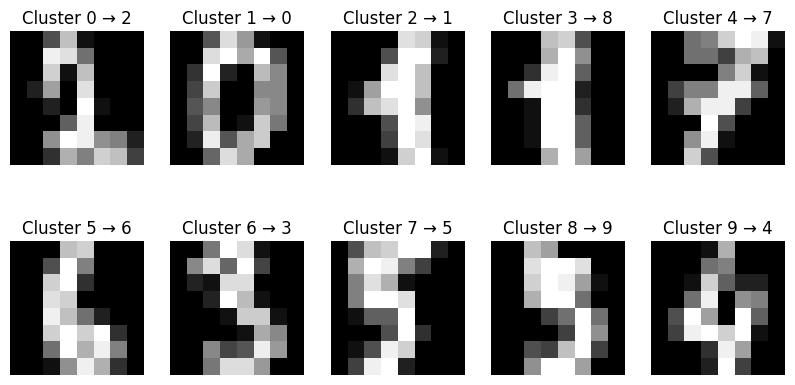

In [27]:
exampleOfCluster(X_data, cluster_labels, cluster_map)

#### Analyze Unsupervised Model Performance

Now let's analyze the performance of the model. Let's see how many missclassified digits are in each cluster

In [28]:
numMisclassified(cluster_labels, cluster_map, y_data)

Misclassified and Total Images per Cluster:
Cluster 0: 28 misclassified images out of 176 total images (16%)
Cluster 1: 2 misclassified images out of 179 total images (1%)
Cluster 2: 34 misclassified images out of 89 total images (38%)
Cluster 3: 124 misclassified images out of 226 total images (55%)
Cluster 4: 28 misclassified images out of 198 total images (14%)
Cluster 5: 5 misclassified images out of 182 total images (3%)
Cluster 6: 26 misclassified images out of 181 total images (14%)
Cluster 7: 20 misclassified images out of 157 total images (13%)
Cluster 8: 102 misclassified images out of 241 total images (42%)
Cluster 9: 2 misclassified images out of 168 total images (1%)


Let's peek into some of the missclassified and correctly classified digits. Try different clusters and see the correctly and incorrectly classified images. Can you name some traits of some of the clusters? 

In [29]:
cluster = 2

Cluster 2: 34 misclassified images


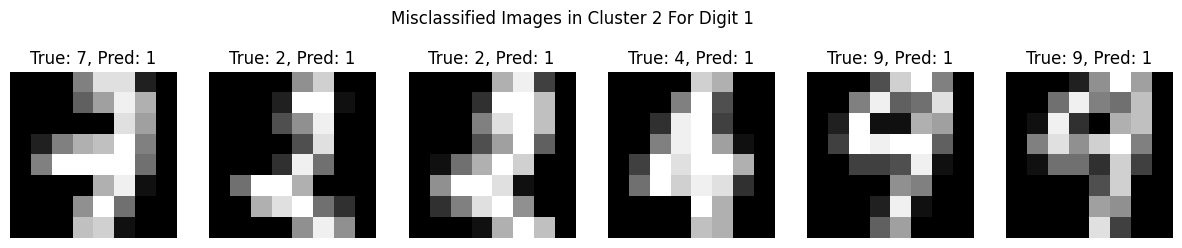

Cluster 2: 55 correctly classified images


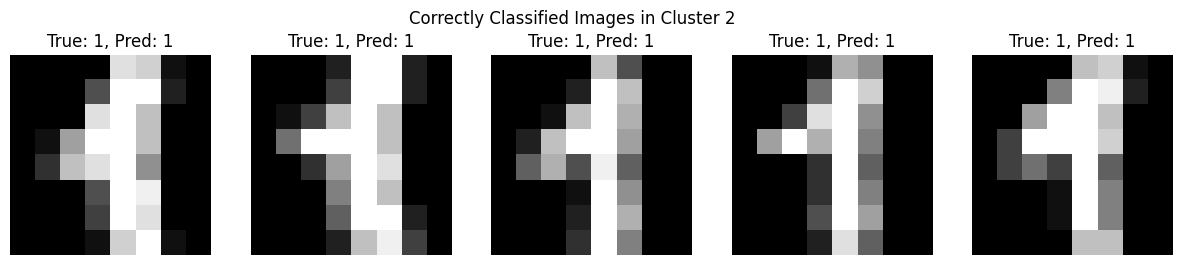

In [30]:
showMisclassified(X_data, y_data, cluster_labels, cluster_map, cluster)
showCorrectClassification(X_data, cluster_labels, cluster_map, y_data, cluster)

How does this model compare to the supervised model? What are the pros and cons of each model? In what scenarios would you want to use supervised vs unsupervised models?